<a href="https://colab.research.google.com/github/wenjunsun/Covid-19-analysis-with-uw-ubicomp/blob/master/2020-11/stratified_analysis_with_google_mobility.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook we want to see average causal effect in differnet propensity buckets (`0 - 0.75, 0.75 - 0.85, 0.85 - 1`).

first we will see average effect just based on the propensity buckets

then we will see the average effect of differnet propensity buckets, comparing SIP counties and no SIP counties.

# 0. Go do data directory

In [ ]:
cd drive/My\ Drive/covid/PSM/data

[Errno 2] No such file or directory: 'drive/My Drive/covid/PSM/data'
/content


In [ ]:
ls

final_data_google_and_safe_graph_up_to_6_1.csv  sample_data/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 0.1. load R packages into Colab

In [ ]:
%load_ext rpy2.ipython
# For (automatic) translation of Pandas objects to R
from rpy2.robjects import pandas2ri
pandas2ri.activate()

/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


In [ ]:
# for box and whisker plot
%%R
install.packages('lattice')
library(lattice)

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/lattice_0.20-41.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 389631 bytes (380 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[wr

In [ ]:
# install package for gradient boosting machine to estimate propensity score
%%R
install.packages('twang')
library(twang)

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: also installing the dependencies ‘minqa’, ‘numDeriv’, ‘mitools’, ‘png’, ‘jpeg’, ‘gbm’, ‘survey’, ‘xtable’, ‘latticeExtra’


R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/minqa_1.2.4.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 53548 bytes (52 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[w

In [ ]:
%%R
install.packages('survey')
library('survey')

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/survey_4.0.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 1558121 bytes (1.5 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write 

# 1. load/prepare data

In [ ]:
data = pd.read_csv('final_data_google_and_safe_graph_up_to_6_1.csv')

In [ ]:
data

,state,state_code,State Name,cnamelong,county_code,diff_in_perc_at_home,SIP?,Median Household Income,% Rural,Population_y,political_diff,% less than 18 years of age,% 65 and over,% Asian,% Black,% Hispanic,% Non-Hispanic White,census_fips_code,avg_retail_and_recreation_percent_change_6_1,avg_grocery_and_pharmacy_percent_change_6_1,avg_parks_percent_change_6_1,avg_transit_stations_percent_change_6_1,avg_workplaces_percent_change_6_1,avg_residential_percent_change_6_1
0,1.0,AL,Alabama,Autauga County,1001.0,0.050678,1,59338.0,42.0,55601,-0.494789,23.7,15.6,1.2,19.3,3.0,74.3,1001.0,-9.240741,9.111111,-34.000000,NaN,-22.481481,9.480000
1,1.0,AL,Alabama,Baldwin County,1003.0,0.050312,1,57588.0,42.3,218022,-0.577862,21.6,20.4,1.2,8.8,4.6,83.1,1003.0,-12.944444,6.120370,23.500000,-6.361111,-19.777778,6.564815
2,1.0,AL,Alabama,Barbour County,1005.0,0.007037,1,34382.0,67.8,24881,-0.056112,20.9,19.4,0.5,48.0,4.3,45.6,1005.0,2.608696,-6.203704,NaN,NaN,-15.333333,NaN
3,1.0,AL,Alabama,Bibb County,1007.0,0.011809,1,46064.0,68.4,22400,-0.555441,20.5,16.5,0.2,21.1,2.6,74.6,1007.0,0.823529,5.571429,NaN,NaN,-18.175926,NaN
4,1.0,AL,Alabama,Blount County,1009.0,0.038890,1,50412.0,90.0,57840,-0.813820,23.2,18.2,0.3,1.5,9.6,86.9,1009.0,-6.372093,6.118812,NaN,NaN,-21.111111,8.720000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2823,56.0,WY,Wyoming,Sweetwater County,56037.0,-0.018485,0,73315.0,10.9,43051,-0.535382,26.2,12.1,1.0,1.1,16.1,79.3,56037.0,-11.537037,7.305882,NaN,13.888889,-20.231481,7.120000
2824,56.0,WY,Wyoming,Teton County,56039.0,0.075183,1,99087.0,46.4,23081,0.278663,18.4,15.4,1.4,0.6,14.9,81.5,56039.0,-39.369048,-17.661017,-24.018868,-38.691358,-37.574074,NaN
2825,56.0,WY,Wyoming,Uinta County,56041.0,0.010157,0,63401.0,43.1,20299,-0.614926,28.8,14.1,0.5,0.7,9.2,87.4,56041.0,-1.125000,14.352941,NaN,12.537037,-16.435185,NaN
2826,56.0,WY,Wyoming,Washakie County,56043.0,-0.007825,0,55190.0,36.0,7885,-0.640377,22.7,21.7,0.8,0.5,14.1,82.4,56043.0,-2.767442,-12.000000,NaN,NaN,-20.960526,NaN


In [ ]:
data = data.drop(['avg_parks_percent_change_6_1', 'avg_transit_stations_percent_change_6_1',
                  'avg_residential_percent_change_6_1'], axis = 1)

In [ ]:
data.dropna(subset = ['avg_retail_and_recreation_percent_change_6_1',
                      'avg_grocery_and_pharmacy_percent_change_6_1',
                      'avg_workplaces_percent_change_6_1'], inplace = True)

In [ ]:
data.isnull().sum()

state                                           0
state_code                                      0
State Name                                      0
cnamelong                                       0
county_code                                     0
diff_in_perc_at_home                            0
SIP?                                            0
Median Household Income                         0
% Rural                                         0
Population_y                                    0
political_diff                                  0
% less than 18 years of age                     0
% 65 and over                                   0
% Asian                                         0
% Black                                         0
% Hispanic                                      0
% Non-Hispanic White                            0
census_fips_code                                0
avg_retail_and_recreation_percent_change_6_1    0
avg_grocery_and_pharmacy_percent_change_6_1     0


In [ ]:
data.shape

(2415, 21)

In [ ]:
data[data['SIP?'] == 0]

,state,state_code,State Name,cnamelong,county_code,diff_in_perc_at_home,SIP?,Median Household Income,% Rural,Population_y,political_diff,% less than 18 years of age,% 65 and over,% Asian,% Black,% Hispanic,% Non-Hispanic White,census_fips_code,avg_retail_and_recreation_percent_change_6_1,avg_grocery_and_pharmacy_percent_change_6_1,avg_workplaces_percent_change_6_1
94,5.0,AR,Arkansas,Arkansas County,5001.0,0.002032,0,43887.0,34.7,17769,-0.305821,22.9,19.6,0.8,24.5,3.3,69.5,5001.0,-8.648148,4.566038,-14.157895
95,5.0,AR,Arkansas,Ashley County,5003.0,0.004202,0,41127.0,51.7,20046,-0.365018,22.9,20.4,0.3,24.5,5.5,68.3,5003.0,-9.058824,3.450980,-16.283019
96,5.0,AR,Arkansas,Baxter County,5005.0,-0.000820,0,39686.0,65.8,41619,-0.536072,17.7,30.9,0.5,0.4,2.5,94.5,5005.0,-3.027778,13.000000,-15.777778
97,5.0,AR,Arkansas,Benton County,5007.0,0.075433,0,68978.0,25.2,272608,-0.348571,26.3,13.4,4.1,1.8,16.9,73.0,5007.0,-15.111111,-1.055556,-28.601852
98,5.0,AR,Arkansas,Boone County,5009.0,-0.000736,0,44482.0,62.2,37480,-0.584465,22.9,20.7,0.7,0.4,2.6,93.6,5009.0,-5.212963,6.073684,-21.611111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2822,56.0,WY,Wyoming,Sublette County,56035.0,0.042121,0,74570.0,100.0,9813,-0.643472,22.5,19.5,0.7,0.8,7.5,89.0,56035.0,-25.159091,-19.428571,-24.368421
2823,56.0,WY,Wyoming,Sweetwater County,56037.0,-0.018485,0,73315.0,10.9,43051,-0.535382,26.2,12.1,1.0,1.1,16.1,79.3,56037.0,-11.537037,7.305882,-20.231481
2825,56.0,WY,Wyoming,Uinta County,56041.0,0.010157,0,63401.0,43.1,20299,-0.614926,28.8,14.1,0.5,0.7,9.2,87.4,56041.0,-1.125000,14.352941,-16.435185
2826,56.0,WY,Wyoming,Washakie County,56043.0,-0.007825,0,55190.0,36.0,7885,-0.640377,22.7,21.7,0.8,0.5,14.1,82.4,56043.0,-2.767442,-12.000000,-20.960526


In [ ]:
data[data['SIP?'] == 1]

,state,state_code,State Name,cnamelong,county_code,diff_in_perc_at_home,SIP?,Median Household Income,% Rural,Population_y,political_diff,% less than 18 years of age,% 65 and over,% Asian,% Black,% Hispanic,% Non-Hispanic White,census_fips_code,avg_retail_and_recreation_percent_change_6_1,avg_grocery_and_pharmacy_percent_change_6_1,avg_workplaces_percent_change_6_1
0,1.0,AL,Alabama,Autauga County,1001.0,0.050678,1,59338.0,42.0,55601,-0.494789,23.7,15.6,1.2,19.3,3.0,74.3,1001.0,-9.240741,9.111111,-22.481481
1,1.0,AL,Alabama,Baldwin County,1003.0,0.050312,1,57588.0,42.3,218022,-0.577862,21.6,20.4,1.2,8.8,4.6,83.1,1003.0,-12.944444,6.120370,-19.777778
2,1.0,AL,Alabama,Barbour County,1005.0,0.007037,1,34382.0,67.8,24881,-0.056112,20.9,19.4,0.5,48.0,4.3,45.6,1005.0,2.608696,-6.203704,-15.333333
3,1.0,AL,Alabama,Bibb County,1007.0,0.011809,1,46064.0,68.4,22400,-0.555441,20.5,16.5,0.2,21.1,2.6,74.6,1007.0,0.823529,5.571429,-18.175926
4,1.0,AL,Alabama,Blount County,1009.0,0.038890,1,50412.0,90.0,57840,-0.813820,23.2,18.2,0.3,1.5,9.6,86.9,1009.0,-6.372093,6.118812,-21.111111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2802,55.0,WI,Wisconsin,Waupaca County,55135.0,0.018980,1,58648.0,64.9,51128,-0.302460,20.3,20.9,0.6,0.5,3.3,94.1,55135.0,-12.425926,2.777778,-18.157407
2803,55.0,WI,Wisconsin,Waushara County,55137.0,-0.019303,1,52340.0,89.5,24263,-0.323301,18.3,24.4,0.6,2.0,6.3,89.6,55137.0,-16.862745,7.509804,-18.944444
2804,55.0,WI,Wisconsin,Winnebago County,55139.0,0.071851,1,57785.0,13.4,171020,-0.074431,20.5,16.4,3.0,2.2,4.2,88.4,55139.0,-23.888889,-8.194444,-23.657407
2805,55.0,WI,Wisconsin,Wood County,55141.0,0.007077,1,55879.0,36.7,73055,-0.192777,21.6,20.6,2.0,0.9,3.1,92.2,55141.0,-14.935185,-4.879630,-21.537037


 # 2. prepare propensisty weights

In [ ]:
dataframe = data

In [ ]:
%%R -i dataframe

logitModel <- glm(SIP.~Median.Household.Income + X..Rural +
                  political_diff+
                  X..Asian + X..Black + 
                  X..Non.Hispanic.White +
                  X..Hispanic + Population_y, data = dataframe, family = "binomial")

# put the propensity score predicted by logistic regression
# into a new column in the dataframe.
dataframe$weights<-predict(logitModel, type="response")

In [ ]:
%%R
dataframe$weight_ATE <- with(dataframe, ifelse(SIP.==1, 1/weights, 1/(1-weights)))

In [ ]:
# deal with extreme weights
%%R
dataframe$weight_ATE_truncated <- with(dataframe, 
                                       ifelse(weight_ATE > quantile(weight_ATE, 0.99),
                                              quantile(weight_ATE, 0.99),
                                              weight_ATE))

# 3. plot outcome variables vs propensity scatter plot 

In [ ]:
new_data = %R dataframe

In [ ]:
new_data

,state,state_code,State.Name,cnamelong,county_code,diff_in_perc_at_home,SIP.,Median.Household.Income,X..Rural,Population_y,political_diff,X..less.than.18.years.of.age,X..65.and.over,X..Asian,X..Black,X..Hispanic,X..Non.Hispanic.White,census_fips_code,avg_retail_and_recreation_percent_change_6_1,avg_grocery_and_pharmacy_percent_change_6_1,avg_workplaces_percent_change_6_1,weights,weight_ATE,weight_ATE_truncated
0,1.0,AL,Alabama,Autauga County,1001.0,0.050678,1,59338.0,42.0,55601,-0.494789,23.7,15.6,1.2,19.3,3.0,74.3,1001.0,-9.240741,9.111111,-22.481481,0.837857,1.193521,1.193521
1,1.0,AL,Alabama,Baldwin County,1003.0,0.050312,1,57588.0,42.3,218022,-0.577862,21.6,20.4,1.2,8.8,4.6,83.1,1003.0,-12.944444,6.120370,-19.777778,0.951087,1.051428,1.051428
2,1.0,AL,Alabama,Barbour County,1005.0,0.007037,1,34382.0,67.8,24881,-0.056112,20.9,19.4,0.5,48.0,4.3,45.6,1005.0,2.608696,-6.203704,-15.333333,0.975013,1.025627,1.025627
3,1.0,AL,Alabama,Bibb County,1007.0,0.011809,1,46064.0,68.4,22400,-0.555441,20.5,16.5,0.2,21.1,2.6,74.6,1007.0,0.823529,5.571429,-18.175926,0.893805,1.118812,1.118812
4,1.0,AL,Alabama,Blount County,1009.0,0.038890,1,50412.0,90.0,57840,-0.813820,23.2,18.2,0.3,1.5,9.6,86.9,1009.0,-6.372093,6.118812,-21.111111,0.914211,1.093839,1.093839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2823,56.0,WY,Wyoming,Sweetwater County,56037.0,-0.018485,0,73315.0,10.9,43051,-0.535382,26.2,12.1,1.0,1.1,16.1,79.3,56037.0,-11.537037,7.305882,-20.231481,0.605492,2.534802,2.534802
2824,56.0,WY,Wyoming,Teton County,56039.0,0.075183,1,99087.0,46.4,23081,0.278663,18.4,15.4,1.4,0.6,14.9,81.5,56039.0,-39.369048,-17.661017,-37.574074,0.884635,1.130409,1.130409
2825,56.0,WY,Wyoming,Uinta County,56041.0,0.010157,0,63401.0,43.1,20299,-0.614926,28.8,14.1,0.5,0.7,9.2,87.4,56041.0,-1.125000,14.352941,-16.435185,0.700497,3.338863,3.338863
2826,56.0,WY,Wyoming,Washakie County,56043.0,-0.007825,0,55190.0,36.0,7885,-0.640377,22.7,21.7,0.8,0.5,14.1,82.4,56043.0,-2.767442,-12.000000,-20.960526,0.685332,3.177949,3.177949


In [ ]:
new_data_SIP = new_data[new_data['SIP.'] == 1]
new_data_no_SIP = new_data[new_data['SIP.'] == 0]

In [ ]:
new_data_SIP.shape

(2139, 24)

In [ ]:
new_data_no_SIP.shape

(276, 24)

In [ ]:
# the function of plotting one variable against the propensisty score
# given a dataframe.
def plot_variable_against_propensity(dataframe, variable):
  plt.figure(figsize=(8, 8))
  plt.scatter(dataframe['weights'], dataframe[variable])
  plt.xlabel('propensity score')
  plt.ylabel(variable)
  plt.title(f'{variable} vs propensisty score')

## 3.1 `avg_retail_and_recreation_percent_change_6_1` vs propensity score

for all counties:


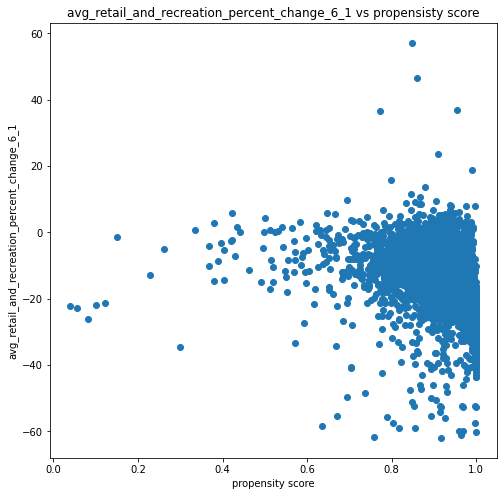

In [ ]:
print('for all counties:')
plot_variable_against_propensity(new_data, 'avg_retail_and_recreation_percent_change_6_1')

for SIP counties:


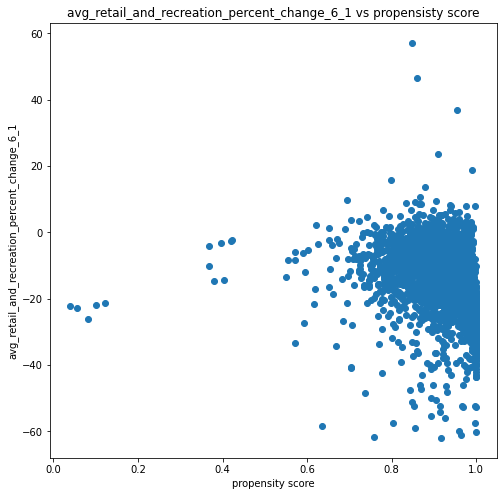

In [ ]:
print('for SIP counties:')
plot_variable_against_propensity(new_data_SIP, 'avg_retail_and_recreation_percent_change_6_1')

for no SIP counties:


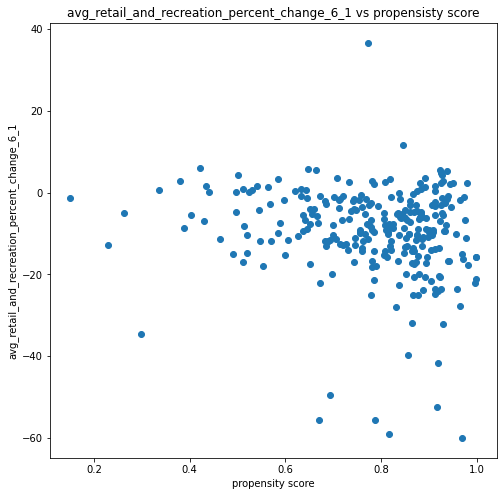

In [ ]:
print('for no SIP counties:')
plot_variable_against_propensity(new_data_no_SIP, 'avg_retail_and_recreation_percent_change_6_1')

## 3.2 `avg_grocery_and_pharmacy_percent_change_6_1` vs propensity score

for all counties:


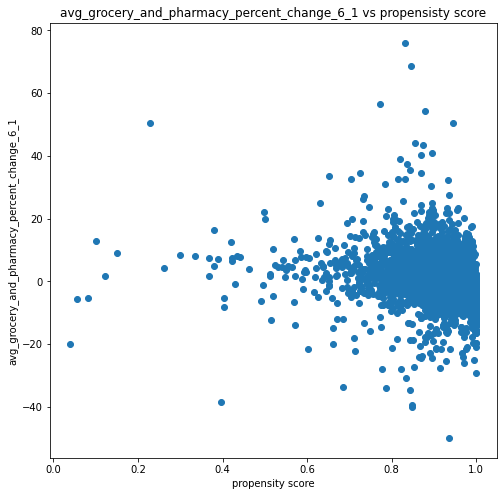

In [ ]:
print('for all counties:')
plot_variable_against_propensity(new_data, 'avg_grocery_and_pharmacy_percent_change_6_1')

for SIP counties:


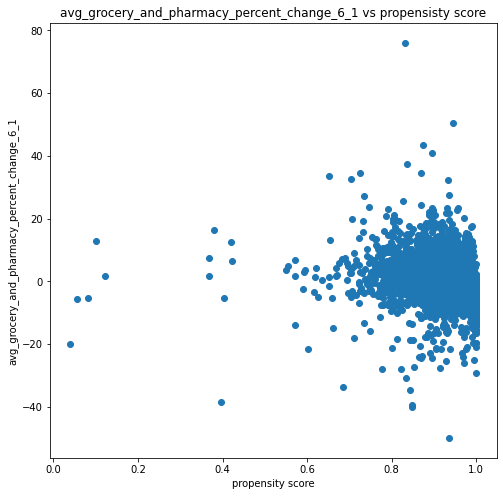

In [ ]:
print('for SIP counties:')
plot_variable_against_propensity(new_data_SIP, 'avg_grocery_and_pharmacy_percent_change_6_1')

for no SIP counties:


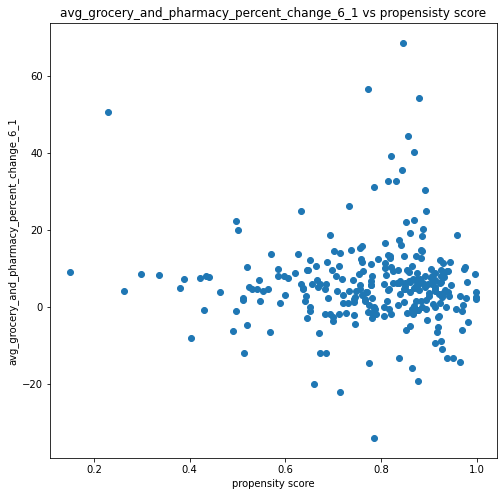

In [ ]:
print('for no SIP counties:')
plot_variable_against_propensity(new_data_no_SIP, 'avg_grocery_and_pharmacy_percent_change_6_1')

## 3.3 `avg_workplaces_percent_change_6_1` vs propensisty score

for all counties:


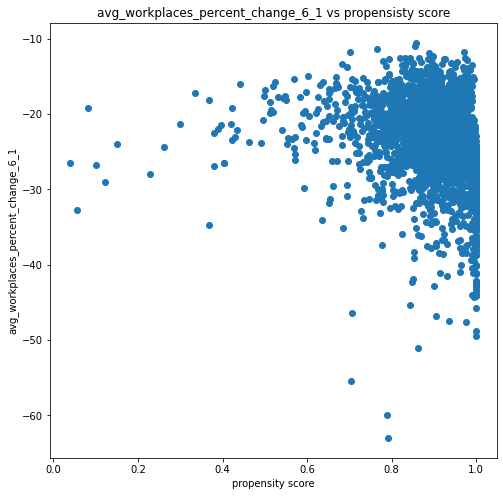

In [ ]:
print('for all counties:')
plot_variable_against_propensity(new_data, 'avg_workplaces_percent_change_6_1')

for SIP counties:


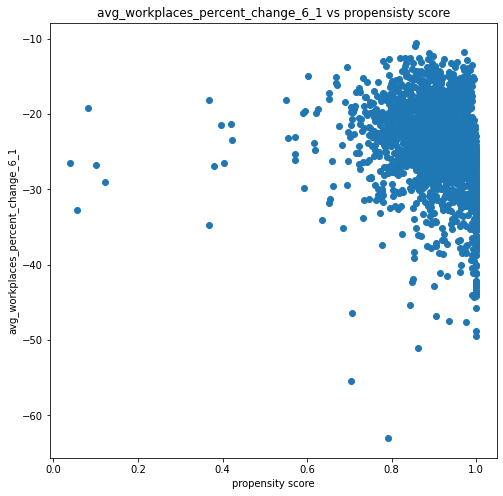

In [ ]:
print('for SIP counties:')
plot_variable_against_propensity(new_data_SIP, 'avg_workplaces_percent_change_6_1')

for no SIP counties:


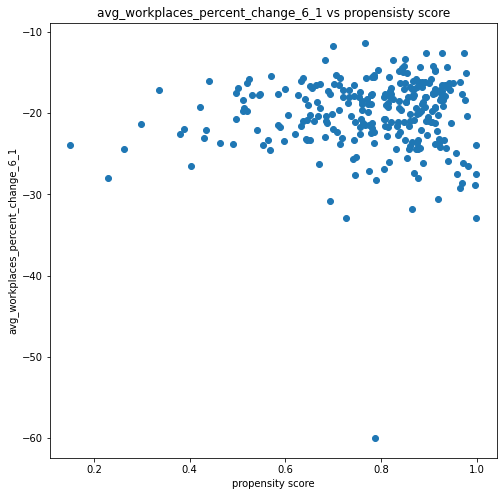

In [ ]:
print('for no SIP counties:')
plot_variable_against_propensity(new_data_no_SIP, 'avg_workplaces_percent_change_6_1')

# 4. create bins of propensity scores

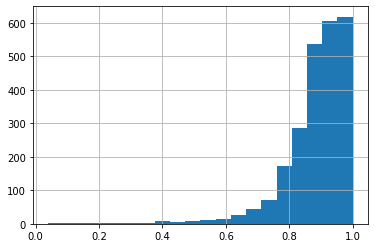

In [ ]:
new_data['weights'].hist(bins = 20)

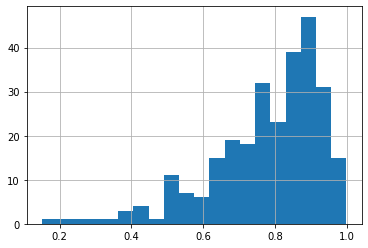

In [ ]:
new_data_no_SIP['weights'].hist(bins = 20)

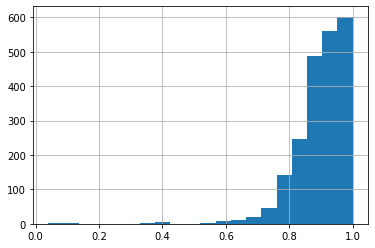

In [ ]:
new_data_SIP['weights'].hist(bins = 20)

In [ ]:
# we decided to cup propensity into 3 non-uniform groups to balance
# the number of data points in each group.
#bins = pd.IntervalIndex.from_tuples([(0, 0.75), (0.75, 0.85), (0.85, 1)])
# create propensity buckets for new_data
#propensity_buckets = pd.cut(new_data['weights'], bins)
propensity_buckets = pd.qcut(new_data['weights'], 20)
new_data['propensity_bucket'] = propensity_buckets

# create propensity buckets for new_data_no_SIP
#propensity_buckets = pd.cut(new_data_no_SIP['weights'], bins)
propensity_buckets = pd.qcut(new_data_no_SIP['weights'], 10)
new_data_no_SIP['propensity_bucket'] = propensity_buckets

# create propensisty buckets for df_scaled
#propensity_buckets = pd.cut(new_data_SIP['weights'], bins)
propensity_buckets = pd.qcut(new_data_SIP['weights'], 20)
new_data_SIP['propensity_bucket'] = propensity_buckets

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
new_data.head()

,state,state_code,State.Name,cnamelong,county_code,diff_in_perc_at_home,SIP.,Median.Household.Income,X..Rural,Population_y,political_diff,X..less.than.18.years.of.age,X..65.and.over,X..Asian,X..Black,X..Hispanic,X..Non.Hispanic.White,census_fips_code,avg_retail_and_recreation_percent_change_6_1,avg_grocery_and_pharmacy_percent_change_6_1,avg_workplaces_percent_change_6_1,weights,weight_ATE,weight_ATE_truncated,propensity_bucket
0,1.0,AL,Alabama,Autauga County,1001.0,0.050678,1,59338.0,42.0,55601,-0.494789,23.7,15.6,1.2,19.3,3.0,74.3,1001.0,-9.240741,9.111111,-22.481481,0.837857,1.193521,1.193521,"(0.828, 0.848]"
1,1.0,AL,Alabama,Baldwin County,1003.0,0.050312,1,57588.0,42.3,218022,-0.577862,21.6,20.4,1.2,8.8,4.6,83.1,1003.0,-12.944444,6.120370,-19.777778,0.951087,1.051428,1.051428,"(0.943, 0.953]"
2,1.0,AL,Alabama,Barbour County,1005.0,0.007037,1,34382.0,67.8,24881,-0.056112,20.9,19.4,0.5,48.0,4.3,45.6,1005.0,2.608696,-6.203704,-15.333333,0.975013,1.025627,1.025627,"(0.965, 0.977]"
3,1.0,AL,Alabama,Bibb County,1007.0,0.011809,1,46064.0,68.4,22400,-0.555441,20.5,16.5,0.2,21.1,2.6,74.6,1007.0,0.823529,5.571429,-18.175926,0.893805,1.118812,1.118812,"(0.887, 0.896]"
4,1.0,AL,Alabama,Blount County,1009.0,0.038890,1,50412.0,90.0,57840,-0.813820,23.2,18.2,0.3,1.5,9.6,86.9,1009.0,-6.372093,6.118812,-21.111111,0.914211,1.093839,1.093839,"(0.905, 0.915]"


# 5. average treatment effects in different buckets

We will use propensisty weighing methods to calculate the causal effects in each bucket (using the variable `weight_ATE_truncated	`)

In [ ]:
# given a dataframe, print the average treatment effects of the outcome
# variable specified in each propensisty_bucket, weighted by weight_ATE_truncated.
def print_behavior_change_for_dataframe(dataframe, variable):
  for bin in sorted(dataframe['propensity_bucket'].unique()):
    data_in_this_bin = dataframe[dataframe['propensity_bucket'] == bin]
    num_data_in_this_bin = data_in_this_bin.shape[0]
    print(f'there are {num_data_in_this_bin} points in this bin {bin}')

    # num_of_data_points = data_in_this_bin.shape[0]
    # print(f'propensity score from {bin.left} to {bin.right} has {num_of_data_points} data points')

    # print the average change of behavior for this bin.
    average_change_of_behavior = np.average(data_in_this_bin[variable], 
                                            weights = data_in_this_bin['weight_ATE_truncated'])
    print(f'the behavioral change on variable {variable} is {average_change_of_behavior}')
    print(data_in_this_bin.mean())


## 6.1 `avg_retail_and_recreation_percent_change_6_1` treatment effect in diff. buckets

In [ ]:
print('for all counties:')
print_behavior_change_for_dataframe(new_data, 'avg_retail_and_recreation_percent_change_6_1')

In [ ]:
print('for counties without SIP:')
print_behavior_change_for_dataframe(new_data_no_SIP, 'avg_retail_and_recreation_percent_change_6_1')

for counties without SIP:
there are 28 points in this bin (0.15, 0.558]
the behavioral change on variable avg_retail_and_recreation_percent_change_6_1 is -6.099604099027712
state                                              41.678571
county_code                                     41754.214286
diff_in_perc_at_home                                0.013330
SIP.                                                0.000000
Median.Household.Income                         47711.892857
X..Rural                                           58.039286
Population_y                                    27961.357143
political_diff                                     -0.462681
X..less.than.18.years.of.age                       24.314286
X..65.and.over                                     17.928571
X..Asian                                            0.657143
X..Black                                            2.785714
X..Hispanic                                         5.446429
X..Non.Hispanic.White             

In [ ]:
print('for counties with SIP:')
print_behavior_change_for_dataframe(new_data_SIP, 'avg_retail_and_recreation_percent_change_6_1')

for counties with SIP:
there are 107 points in this bin (0.0392, 0.764]
the behavioral change on variable avg_retail_and_recreation_percent_change_6_1 is -14.589033055820995
state                                              29.476636
county_code                                     29616.018692
diff_in_perc_at_home                                0.024529
SIP.                                                1.000000
Median.Household.Income                         55923.682243
X..Rural                                           37.081308
Population_y                                    33442.504673
political_diff                                     -0.373550
X..less.than.18.years.of.age                       22.980374
X..65.and.over                                     18.615888
X..Asian                                            1.330841
X..Black                                            2.770093
X..Hispanic                                         7.382243
X..Non.Hispanic.White            

## 6.2 `avg_grocery_and_pharmacy_percent_change_6_1` treatment effect in diff. buckets

In [ ]:
print('for all counties:')
print_behavior_change_for_dataframe(new_data, 'avg_grocery_and_pharmacy_percent_change_6_1')

for all counties:
there are 121 points in this bin (0.0392, 0.707]
the behavioral change on variable avg_grocery_and_pharmacy_percent_change_6_1 is 1.820668866802603
state                                              37.297521
county_code                                     37403.181818
diff_in_perc_at_home                                0.016130
SIP.                                                0.404959
Median.Household.Income                         53572.933884
X..Rural                                           44.596694
Population_y                                    30281.024793
political_diff                                     -0.442529
X..less.than.18.years.of.age                       23.971901
X..65.and.over                                     17.959504
X..Asian                                            1.039669
X..Black                                            2.347934
X..Hispanic                                         6.943802
X..Non.Hispanic.White                    

In [ ]:
print('for counties without SIP:')
print_behavior_change_for_dataframe(new_data_no_SIP, 'avg_grocery_and_pharmacy_percent_change_6_1')

for counties without SIP:
there are 28 points in this bin (0.15, 0.558]
the behavioral change on variable avg_grocery_and_pharmacy_percent_change_6_1 is 5.371145834442712
state                                              41.678571
county_code                                     41754.214286
diff_in_perc_at_home                                0.013330
SIP.                                                0.000000
Median.Household.Income                         47711.892857
X..Rural                                           58.039286
Population_y                                    27961.357143
political_diff                                     -0.462681
X..less.than.18.years.of.age                       24.314286
X..65.and.over                                     17.928571
X..Asian                                            0.657143
X..Black                                            2.785714
X..Hispanic                                         5.446429
X..Non.Hispanic.White               

In [ ]:
print('for counties with SIP:')
print_behavior_change_for_dataframe(new_data_SIP, 'avg_grocery_and_pharmacy_percent_change_6_1')

for counties with SIP:
there are 107 points in this bin (0.0392, 0.764]
the behavioral change on variable avg_grocery_and_pharmacy_percent_change_6_1 is 0.24757163015772193
state                                              29.476636
county_code                                     29616.018692
diff_in_perc_at_home                                0.024529
SIP.                                                1.000000
Median.Household.Income                         55923.682243
X..Rural                                           37.081308
Population_y                                    33442.504673
political_diff                                     -0.373550
X..less.than.18.years.of.age                       22.980374
X..65.and.over                                     18.615888
X..Asian                                            1.330841
X..Black                                            2.770093
X..Hispanic                                         7.382243
X..Non.Hispanic.White             

## 6.3 `avg_workplaces_percent_change_6_1` treatment effect in diff. buckets

In [ ]:
print('for all counties:')
print_behavior_change_for_dataframe(new_data, 'avg_workplaces_percent_change_6_1')

for all counties:
there are 121 points in this bin (0.0392, 0.707]
the behavioral change on variable avg_workplaces_percent_change_6_1 is -22.236759105513983
state                                              37.297521
county_code                                     37403.181818
diff_in_perc_at_home                                0.016130
SIP.                                                0.404959
Median.Household.Income                         53572.933884
X..Rural                                           44.596694
Population_y                                    30281.024793
political_diff                                     -0.442529
X..less.than.18.years.of.age                       23.971901
X..65.and.over                                     17.959504
X..Asian                                            1.039669
X..Black                                            2.347934
X..Hispanic                                         6.943802
X..Non.Hispanic.White                            

In [ ]:
print('for counties without SIP:')
print_behavior_change_for_dataframe(new_data_no_SIP, 'avg_workplaces_percent_change_6_1')

for counties without SIP:
there are 28 points in this bin (0.15, 0.558]
the behavioral change on variable avg_workplaces_percent_change_6_1 is -20.361310227668145
state                                              41.678571
county_code                                     41754.214286
diff_in_perc_at_home                                0.013330
SIP.                                                0.000000
Median.Household.Income                         47711.892857
X..Rural                                           58.039286
Population_y                                    27961.357143
political_diff                                     -0.462681
X..less.than.18.years.of.age                       24.314286
X..65.and.over                                     17.928571
X..Asian                                            0.657143
X..Black                                            2.785714
X..Hispanic                                         5.446429
X..Non.Hispanic.White                       

In [ ]:
print('for counties with SIP:')
print_behavior_change_for_dataframe(new_data_SIP, 'avg_workplaces_percent_change_6_1')

for counties with SIP:
there are 107 points in this bin (0.0392, 0.764]
the behavioral change on variable avg_workplaces_percent_change_6_1 is -24.48632918791887
state                                              29.476636
county_code                                     29616.018692
diff_in_perc_at_home                                0.024529
SIP.                                                1.000000
Median.Household.Income                         55923.682243
X..Rural                                           37.081308
Population_y                                    33442.504673
political_diff                                     -0.373550
X..less.than.18.years.of.age                       22.980374
X..65.and.over                                     18.615888
X..Asian                                            1.330841
X..Black                                            2.770093
X..Hispanic                                         7.382243
X..Non.Hispanic.White                        

# conclusion

As we can see, the causal effect of most of the behavioral data doesn't change as we vary from differnet propensity bucket to next. The causal effect is pretty uniform it seems like